## <div align='center'>NASA Boeing 777-200ER (N577NA) range Estimates for Antarctica</div>

This Jupyter notebook estimates ranges over Antarctica for the NASA Boeing 777 (B777-200ER) a.k.a. 'the triple seven' airborne science laboratory.

### 1) Load required Python modules, processing options, parameters and necessary maps:

In [136]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy as sp
import xarray as xr
from matplotlib import colors
from osgeo import gdal
from pyproj import Geod, Transformer
from scipy.interpolate import PchipInterpolator

gdal.UseExceptions()

VERBOSE = False

takeoff_penalty	= 15 / 60 #  time it takes to get on track following takeoff, hr
landing_penalty	= 15 / 60 # time it takes to get lined up for landing, hr
time_inc		= 5 / 60 # time increment, hr
decim_bm        = 50

### 2) Load BedMachine mask, MOA and associated products

In [2]:
# BedMachine Antarctica v3 path and file name
path_bm = '/Users/jamacgre/OneDrive - NASA/research/data/antarctica/BedMachine/'
file_bm = 'BedMachineAntarctica-v3.nc'

bm = xr.open_dataset(path_bm + file_bm)

x_bm = bm.x.values.astype(np.float32)
y_bm = bm.y.values.astype(np.float32)
xx_bm, yy_bm = np.meshgrid(x_bm, y_bm)

mask_bm = bm['mask'].values
mask_bm[mask_bm > 0] = 1
mask_bm_decim = mask_bm[::decim_bm, ::decim_bm].astype(bool)

bm.close()

x_decim, y_decim = x_bm[::decim_bm], y_bm[::decim_bm]
xx_decim, yy_decim = np.meshgrid(x_decim, y_decim)
EPSG3031_to_WGS84 = Transformer.from_crs('EPSG:3031', 'EPSG:4326')
lat_decim, lon_decim = EPSG3031_to_WGS84.transform(xx_decim, yy_decim)

# MOA 2008-9 mosaic/coastline/grounding-line/islands in EPSG:3031 already
path_moa = '/Users/jamacgre/OneDrive - NASA/research/data/moa/new/'
file_moa = 'moa750_2009_hp1_v1.1.tif'
file_coastline = 'moa_2009_coastline_v1.1.shp'
file_grounding_line = 'moa_2009_groundingline_v1.1.shp'
file_islands = 'moa_2009_islands_v1.1.shp'

moa_inst = gdal.Open(path_moa + file_moa)
moa = moa_inst.GetRasterBand(1).ReadAsArray()
moa_gt = moa_inst.GetGeoTransform()
moa_x_sz = moa_inst.RasterXSize
moa_y_sz = moa_inst.RasterYSize
x_min_moa, x_max_moa, y_min_moa, y_max_moa = moa_gt[0], moa_gt[0] + (moa_gt[1] * moa_x_sz), moa_gt[3], moa_gt[3] + (moa_gt[5] * moa_y_sz)
moa_inst.Close()

moa_cl = gpd.read_file(path_moa + file_coastline)
moa_gl = gpd.read_file(path_moa + file_grounding_line)
moa_il = gpd.read_file(path_moa + file_islands)

### 3) Set aircraft performance parameters

In [4]:
class Aircraft():
    def __init__(self):
        self.Name            = 'NASA B777-200ER' # aircraft name
        self.ShortName       = '777'             # aircraft short name
        self.MTOW            = 650e3             # maximum take-off weight, lb
        self.OEW             = 321e3             # operating empty weight incl. crew, lb
        self.MissionLoad     = 45e3              # load for mission operations incl. QNCs + instruments, lb
        self.FuelTotal       = 308e3             # fuel total, lb
        self.FuelTotalOp     = 280e3             # operational fuel total (assuming tanks are not completely filed), lb
        self.FuelReserveTime = 90                # minimum fuel reserve, lb
        self.SpeedCruise     = 460               # high-altitude cruise speed, kt
        self.SpeedLo         = 275               # low-alititude survey speed, kt
        self.SpeedLoPenalty  = 2                 # fuel burn penalty ratio for jet low-flying compared to cruise, dimensionless
        self.ETOPS           = 330               # ETOPS for aircraft type (B777-200ER), min (currently not used)

# create return variable 'aircraft_params' as an Aircraft class with fields populated
ac = Aircraft()

if VERBOSE:
    print(f'The OEW of the {ac.name:s} is {ac.OEW:.1f} lbs.')

# 777 specific stats from https://community.infiniteflight.com/t/your-guide-to-fuel-burn-and-cruising-altitudes-in-the-new-777-family-ignore-777f/488605
load_range_ref = np.arange(0.1, (1.0 + 0.1), 0.1)
fuel_burn_per_load = np.vstack((load_range_ref,
                                (1e3 * np.array((8.5, 9.0, 10.4, 10.9, 11.8, 12.4, 13.2, 14.1, 14.9, 15.8))),
                                (1e3 * np.array((10.0, 10.5, 11.7, 12.3, 12.2, 12.9, 13.9, 14.6, 15.7, 16.7))))) # row 1: percentage load; row 2: lowest burn rate in lbs/hr; row 3: lbs/hr higest of burn rates at that load
fuel_burn_per_load = np.vstack((fuel_burn_per_load, 
                                np.mean(fuel_burn_per_load[1:3, :], axis=0))) # mean of high and low

ac.SpeedCruise = ac.SpeedCruise * 1.852e3 # convert from kt to m/hr
ac.SpeedLo = ac.SpeedLo * 1.852e3 # convert from kt to m/hr
ac.WtStart = ac.OEW + ac.MissionLoad + ac.FuelTotalOp # total starting weight, lb
ac.WtSpare = ac.MTOW - ac.WtStart # spare (unused) weight, lb
if ac.WtSpare < 0: # need some spare weight!
    print(ac.Name + ' too heavy!!! (starting weight > MTOW)')
ac.LoadMax = ac.MTOW - ac.OEW # max load, lb
ac.BurnRateHiRange = fuel_burn_per_load[3, :] # using internet values from above
ac.BurnRateLoRange = ac.SpeedLoPenalty * ac.BurnRateHiRange # penalty for low-flying with jet, based on G-V experience
ac.BurnRateHiInterp = PchipInterpolator(load_range_ref, 
                                        ac.BurnRateHiRange, 
                                        extrapolate=True)
ac.BurnRateLoInterp = PchipInterpolator(load_range_ref, 
                                        ac.BurnRateLoRange, 
                                        extrapolate=True)
ac.FuelReserveWt = (ac.FuelReserveTime / 60) * ac.BurnRateHiInterp((ac.OEW + ac.MissionLoad + (0.2 * ac.FuelTotalOp)) / ac.LoadMax) # assume reserve only needed at lower load, lb
ac.WtEnd = ac.OEW + ac.MissionLoad + ac.FuelReserveWt # weight at end assuming we still have reserve, lb
ac.LoadStart = (ac.WtStart - ac.OEW) / ac.LoadMax # load ratio at start, dimensionless
ac.LoadEnd = (ac.WtEnd  - ac.OEW) / ac.LoadMax # load ratio at end, dimensionless

### 4) Load bases of operation

In [5]:
file_base = 'bases_of_operation.csv'
base_df = pd.read_csv(file_base)

# not needed here but is good practice: wrap longitudes to ±180° for exporting geographic coordinates 
# 0° to 360° is not supported for GeoPackage (GPKG) format    
base_df['Longitude'] = np.mod(base_df['Longitude'] - 180.0, 360.0) - 180.0

base_gdf = gpd.GeoDataFrame(base_df,
                            geometry=gpd.points_from_xy(base_df['Longitude'], base_df['Latitude']))
# set up the coordinate system for GeoDataPackage
base_gdf = base_gdf.set_crs('EPSG:4326')
# save GeoDataPackage if desired
base_gdf.to_file(file_base.replace('.csv', '.gpkg'), 
                 driver='GPKG')

num_base = len(base_gdf)

base_gdf

,Name,Country,CountryNice,ICAO,Latitude,Longitude,Color,geometry
0,Ushuaia,ARG,Argentina,SAWH,-54.84,-68.30,r,POINT (-68.3 -54.84)
1,Hobart,AUS,Australia,YMHB,-42.84,147.51,b,POINT (147.51 -42.84)
2,Cape Town,ZAF,South Africa,FACT,-33.97,18.60,g,POINT (18.6 -33.97)


In [ ]:
print(base_gdf.geometry[0].x)

### 5) Load example targets

In [13]:
file_target = '2019_Antarctic_targets.kml'

target_gdf = gpd.read_file(file_target, 
                           columns=['Name', 'geometry'])
target_gdf.geometry = target_gdf.geometry.force_2d() # remove z

for target_to_remove in ['88S traverse center', 'Rennick GZ', 'Cook GZ', 'Ninnis GZ', 'Français GZ', 'Underwood GZ', 'Conger GZ', 'Dibble GZ']:
    target_gdf = target_gdf.drop(target_gdf[target_gdf['Name'] == target_to_remove].index)
target_gdf.reset_index(inplace=True)

num_target = len(target_gdf)

target_gdf_proj = target_gdf.copy()
target_gdf_proj = target_gdf.to_crs(epsg=3031)

target_gdf
target_gdf_proj

,index,Name,geometry
0,0,Troll,POINT (2.53461 -72.01342)
1,1,Recovery GZ,POINT (-36.73066 -81.03947)
2,2,South Pole,POINT (-114.71303 -90)
3,4,Matusevich GZ,POINT (157.5714 -69.48946)
4,7,Mertz GZ,POINT (144.14947 -67.87684)
5,10,Frost GZ,POINT (129.26419 -67.07009)
6,11,Totten GZ,POINT (115.52553 -67.1558)
7,14,Denman GZ,POINT (99.27903 -66.76001)
8,15,West IS,POINT (86.39879 -66.49812)
9,16,Sør Rondane GZ,POINT (26.60865 -71.03714)


### 6) Calculate range-at-target survey distance and time

In [14]:
rad_circle = np.deg2rad(np.arange(360 + 1))
num_circle = len(rad_circle)

class Survey():
    def __init__(self):
        self.DistTransit       = np.full((num_target), np.nan) # transit distance between base and target, m
        self.TimeTransit       = np.full((num_target), np.nan) # transit time, hr
        self.FuelTransitOut    = np.full((num_target), np.nan) # fuel required for transit out to target, lb
        self.FuelTransitReturn = np.full((num_target), np.nan) # fuel required for return to base, lb
        self.FuelTransit       = np.full((num_target), np.nan) # total fuel required for out-and-back transit, lb
        self.RangeSurvey       = np.full((num_target), np.nan) # available survey range, m
        self.TimeSurvey        = np.full((num_target), np.nan) # available survey time, hr
        self.XRangeCircle      = np.full((num_target, num_circle), np.nan) # projected x of survey range circle, m
        self.YRangeCircle      = np.full((num_target, num_circle), np.nan) # projected y of survey range circle, m

survey = [None] * num_base
geoid = Geod(ellps='WGS84')

for base in range(num_base):
    
    # initialize Survey instance
    survey[base] = Survey()
    
    # loop through each target, calculate fuel for transit to (starting from op ful) and fuel for transit from (starting from reserve)
    for target in range(num_target):
        
        az1, az2, survey[base].DistTransit[target] = geoid.inv(base_gdf.geometry[base].x,
                                                               base_gdf.geometry[base].y,
                                                               target_gdf.geometry[target].x,
                                                               target_gdf.geometry[target].y) # great-circle transit distance, m
        
        survey[base].TimeTransit[target] = survey[base].DistTransit[target] / ac.SpeedCruise # transit time, hr
        
        # initialize distance, fuel and load
        dist_curr = 0
        fuel_curr = ac.FuelTotalOp
        load_curr = ac.LoadStart
        
        # add in takeoff penalty
        for takeoff in range(np.round(takeoff_penalty / time_inc).astype(int)):
            fuel_burn_curr = ac.BurnRateHiInterp(load_curr) * time_inc # current fuel burn in lbs = rate (lb/hr) * hr
            fuel_curr = fuel_curr - fuel_burn_curr # weight available - weight burned = weight remaining
            load_curr = load_curr - (fuel_burn_curr / ac.LoadMax) # previous load - load just spent (which was all fuel)
        
        # keep going until you reach target
        while (dist_curr < survey[base].DistTransit[target]) & (fuel_curr > ac.FuelReserveWt):
            dist_curr = dist_curr + (time_inc * ac.SpeedCruise) # hr * m/hr = m
            fuel_burn_curr = ac.BurnRateHiInterp(load_curr) * time_inc
            fuel_curr = fuel_curr - fuel_burn_curr
            load_curr = load_curr - (fuel_burn_curr / ac.LoadMax)

        survey[base].FuelTransitOut[target] = ac.FuelTotalOp - fuel_curr
        
        # now reverse starting from base on return, first adding in landing penalty
        dist_curr = 0
        fuel_curr = ac.FuelReserveWt
        load_curr = ac.LoadEnd
        
        for landing in range(np.round(landing_penalty / time_inc).astype(int)):
            fuel_burn_curr = ac.BurnRateHiInterp(load_curr) * time_inc
            fuel_curr = fuel_curr + fuel_burn_curr
            load_curr = load_curr + (fuel_burn_curr / ac.LoadMax)
        
        while dist_curr < survey[base].DistTransit[target]:
            dist_curr = dist_curr + (time_inc * ac.SpeedCruise)
            fuel_burn_curr = ac.BurnRateHiInterp(load_curr) * time_inc
            fuel_curr = fuel_curr + fuel_burn_curr
            load_curr = load_curr + (fuel_burn_curr / ac.LoadMax)
        
        survey[base].FuelTransitReturn[target] = fuel_curr - ac.FuelReserveWt
        
        survey[base].FuelTransit[target] = survey[base].FuelTransitOut[target] + survey[base].FuelTransitReturn[target] # total transit fuel, lb
        
        # skip if too far away
        if survey[base].FuelTransit[target] >= (ac.FuelTotalOp - ac.FuelReserveWt):
            continue
        
        # calculate distance & time at survey altitude/speed on-station
        dist_curr = 0
        fuel_curr = ac.FuelTotalOp - survey[base].FuelTransitOut[target]
        load_curr = ac.LoadStart - (survey[base].FuelTransitOut[target] / ac.LoadMax)
        
        while fuel_curr > survey[base].FuelTransitReturn[target]: # keep going until it's time to turn around
            dist_curr = dist_curr + (time_inc * ac.SpeedLo) # now use low-altitude survey speed
            fuel_burn_curr = ac.BurnRateLoInterp(load_curr) * time_inc
            fuel_curr = fuel_curr - fuel_burn_curr
            load_curr = load_curr - (fuel_burn_curr / ac.LoadMax)
        
        survey[base].RangeSurvey[target] = dist_curr # full range survey
        survey[base].TimeSurvey[target] = dist_curr / ac.SpeedLo # time for full range survey
        survey[base].XRangeCircle[target, :], survey[base].YRangeCircle[target, :] = (target_gdf_proj.geometry[target].x + (np.cos(rad_circle) * (survey[base].RangeSurvey[target] / 2))), \
                                                                                     (target_gdf_proj.geometry[target].y + (np.sin(rad_circle) * (survey[base].RangeSurvey[target] / 2))) # out-and-back range-to-target circle

### 7) Calculate Antarctic-wide gridded range-at-target survey distance and time

In [191]:
decim_shape = (mask_bm_decim.shape[0], mask_bm_decim.shape[1], num_base)
dist_grd, range_grd, time_grd, time_transit_grd = np.full(decim_shape, np.nan), \
                                                  np.full(decim_shape, np.nan), \
                                                  np.full(decim_shape, np.nan), \
                                                  np.full(decim_shape, np.nan)

for base in range(num_base):    
	az1, az2, dist_grd[:, :, base] = geoid.inv(np.full(decim_shape[0:2], base_gdf.geometry[base].x), 
                                               np.full(decim_shape[0:2], base_gdf.geometry[base].y), 
                                               lon_decim,
                                               lat_decim)

ind_mask = np.argwhere(mask_bm_decim)

for pt in range(len(ind_mask)):
    
    if pt % 1e3 == 0:
        print(str(1e2 * (pt / len(ind_mask))) + '%...')
    
    for base in range(num_base):
    
        dist_curr			= 0
        fuel_curr			= ac.FuelTotalOp
        load_curr			= ac.LoadStart
        
        for takeoff in range(np.round(takeoff_penalty / time_inc).astype(int)):
            fuel_burn_curr	= ac.BurnRateHiInterp(load_curr) * time_inc
            fuel_curr		= fuel_curr - fuel_burn_curr
            load_curr		= load_curr - (fuel_burn_curr / ac.LoadMax)
        
        while (dist_curr < dist_grd[ind_mask[pt][0], ind_mask[pt][1], base]) & (fuel_curr > ac.FuelReserveWt):
            dist_curr		= dist_curr + (time_inc * ac.SpeedCruise)
            fuel_burn_curr	= ac.BurnRateHiInterp(load_curr) * time_inc
            fuel_curr		= fuel_curr - fuel_burn_curr
            load_curr		= load_curr - (fuel_burn_curr / ac.LoadMax)
        
        fuel_transit_to_curr= ac.FuelTotalOp - fuel_curr
        dist_curr			= 0
        fuel_curr			= ac.FuelReserveWt
        load_curr			= ac.LoadEnd
        
        for landing in range(np.round(landing_penalty / time_inc).astype(int)):
            fuel_burn_curr	= ac.BurnRateHiInterp(load_curr) * time_inc
            fuel_curr		= fuel_curr + fuel_burn_curr
            load_curr		= load_curr + (fuel_burn_curr / ac.LoadMax)
        
        while dist_curr < dist_grd[ind_mask[pt][0], ind_mask[pt][1], base]:
            dist_curr		= dist_curr + (time_inc * ac.SpeedCruise)
            fuel_burn_curr	= ac.BurnRateHiInterp(load_curr) * time_inc
            fuel_curr		= fuel_curr + fuel_burn_curr
            load_curr		= load_curr + (fuel_burn_curr / ac.LoadMax)
        
        fuel_transit_from_curr = fuel_curr - ac.FuelReserveWt
        fuel_transit_tot_curr = fuel_transit_to_curr + fuel_transit_from_curr
        
        if fuel_transit_tot_curr > (ac.FuelTotalOp - ac.FuelReserveWt):
            continue
                
        dist_curr			= 0
        fuel_curr			= ac.FuelTotalOp - fuel_transit_to_curr
        load_curr			= ac.LoadStart - (fuel_transit_to_curr / ac.LoadMax)
        
        while fuel_curr > fuel_transit_from_curr:
            dist_curr		= dist_curr + (time_inc * ac.SpeedLo)
            fuel_burn_curr	= ac.BurnRateLoInterp(load_curr) * time_inc
            fuel_curr		= fuel_curr - fuel_burn_curr
            load_curr		= load_curr - (fuel_burn_curr / ac.LoadMax)
        
        range_grd[ind_mask[pt][0], ind_mask[pt][1], base] = dist_curr
        time_grd[ind_mask[pt][0], ind_mask[pt][1], base] = range_grd[ind_mask[pt][0], ind_mask[pt][1], base] / ac.SpeedLo

0.0%...
4.597489770585261%...
9.194979541170522%...
13.79246931175578%...
18.389959082341043%...
22.987448852926303%...
27.58493862351156%...
32.182428394096824%...
36.77991816468209%...
41.37740793526735%...
45.974897705852605%...
50.57238747643786%...
55.16987724702312%...
59.767367017608386%...
64.36485678819365%...
68.9623465587789%...
73.55983632936417%...
78.15732609994943%...
82.7548158705347%...
87.35230564111995%...
91.94979541170521%...
96.54728518229047%...


### 8) Plot target circles

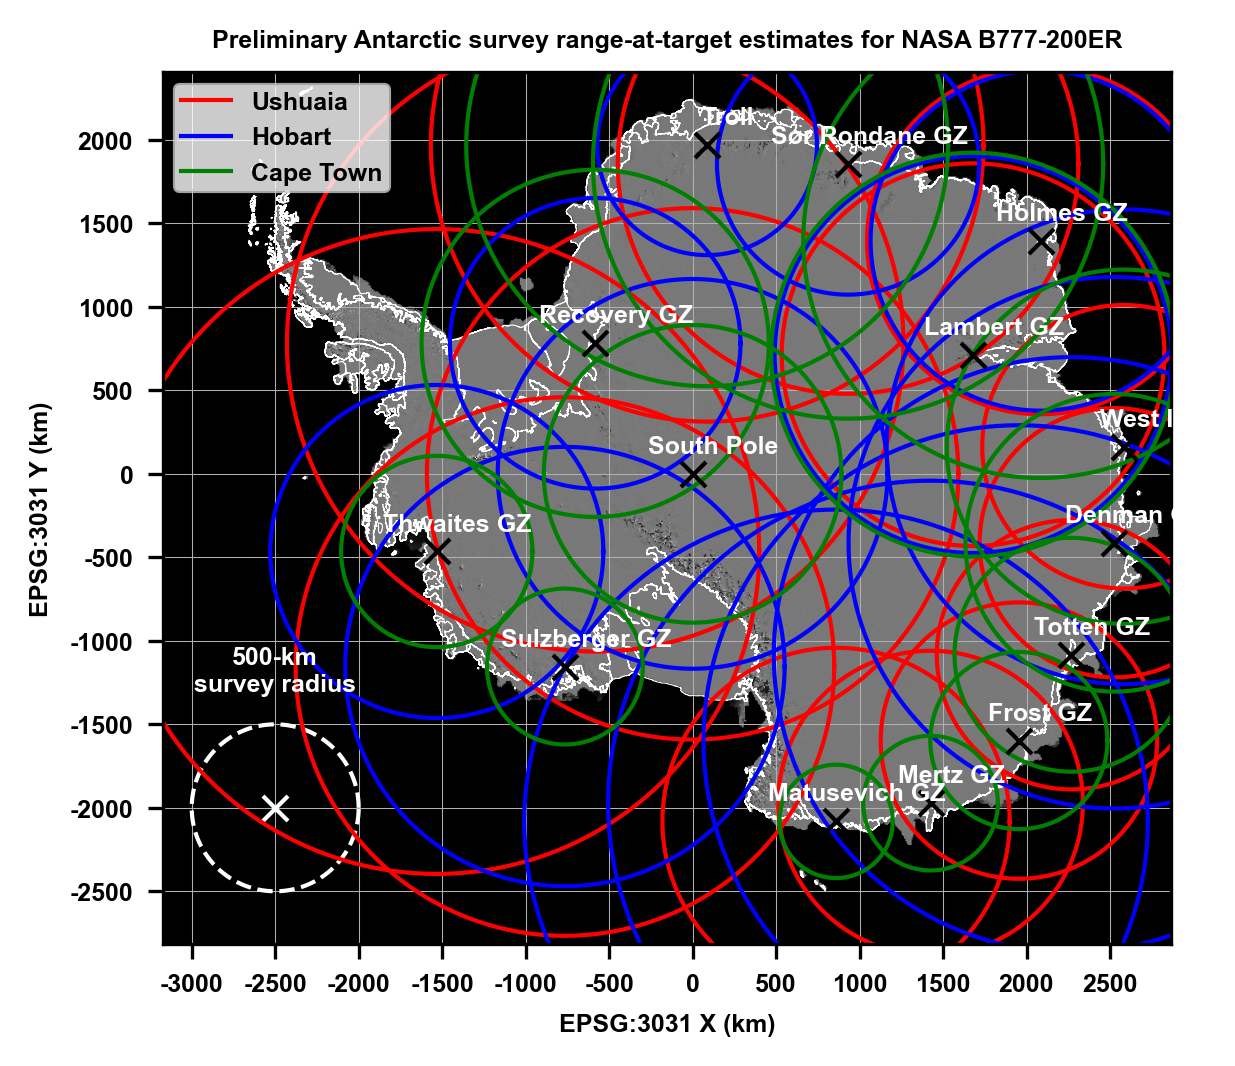

In [192]:
fig, ax = plt.subplots(figsize=(4, 4), dpi=300, facecolor='w', layout='constrained')
plt.imshow(moa[::10, ::10], extent=(x_min_moa, x_max_moa, y_max_moa, y_min_moa), aspect='equal', cmap='gray')
plt.axis(np.array((x_min_moa, x_max_moa, y_max_moa, y_min_moa)))
moa_gl.boundary.plot(color='w', ax=ax, linewidth=0.25)
moa_cl.boundary.plot(color='w', ax=ax, linewidth=0.25)
moa_il.boundary.plot(color='w', ax=ax, linewidth=0.25)
plt.plot(-2.5e6, -2e6, 'wx', linewidth=3)
plt.plot((-2.5e6 + (500e3 * np.cos(rad_circle))), (-2e6 + (500e3 * np.sin(rad_circle))), color='w', linestyle='--', linewidth=1)
plt.text(-2.5e6, (-2e6 + 700e3), '500-km\n' + 'survey radius', color='w', font='Arial', size=6, fontweight='bold', horizontalalignment='center')
p_base = [None] * num_base
for base in range(num_base):
    p_base[base], = plt.plot(0, 0, linewidth=1, color=base_gdf.Color[base])
    for target in range(num_target):
        if survey[base].RangeSurvey[target] != np.nan:
            plt.plot(survey[base].XRangeCircle[target, :],
                     survey[base].YRangeCircle[target, :],
                     linewidth=1,
                     color=base_gdf.Color[base])
for target in range(num_target):
    plt.plot(target_gdf_proj.geometry[target].x, target_gdf_proj.geometry[target].y, 'kx', linewidth=3)
    plt.text((target_gdf_proj.geometry[target].x + 125e3), (target_gdf_proj.geometry[target].y + 125e3), target_gdf.Name[target], color='w', font='Arial', size=6, fontweight='bold', horizontalalignment='center')
plt.xlabel('EPSG:3031 X (km)', font='Arial', size=6, fontweight='bold')
plt.ylabel('EPSG:3031 Y (km)', font='Arial', size=6, fontweight='bold')
plt.title('Preliminary Antarctic survey range-at-target estimates for ' + ac.Name, font='Arial', size=6, fontweight='bold')
plt.xticks(ticks=np.arange(-3e6, 2.5e6 + 5e5, 5e5), labels=np.arange(-3e3, 2.5e3 + 5e2, 5e2).astype(int).astype(str), font='Arial', size=6, fontweight='bold')
plt.yticks(ticks=np.arange(-2.5e6, 2.0e6 + 5e5, 5e5), labels=np.arange(-2.5e3, 2.0e3 + 5e2, 5e2).astype(int).astype(str), font='Arial', size=6, fontweight='bold')
plt.legend(p_base, base_gdf.Name, prop={'family':'Arial', 'size':6, 'weight':'bold'}, borderpad=0.25)
plt.grid(linewidth=0.25)
plt.show()

### 9) Plot range-to-target grids

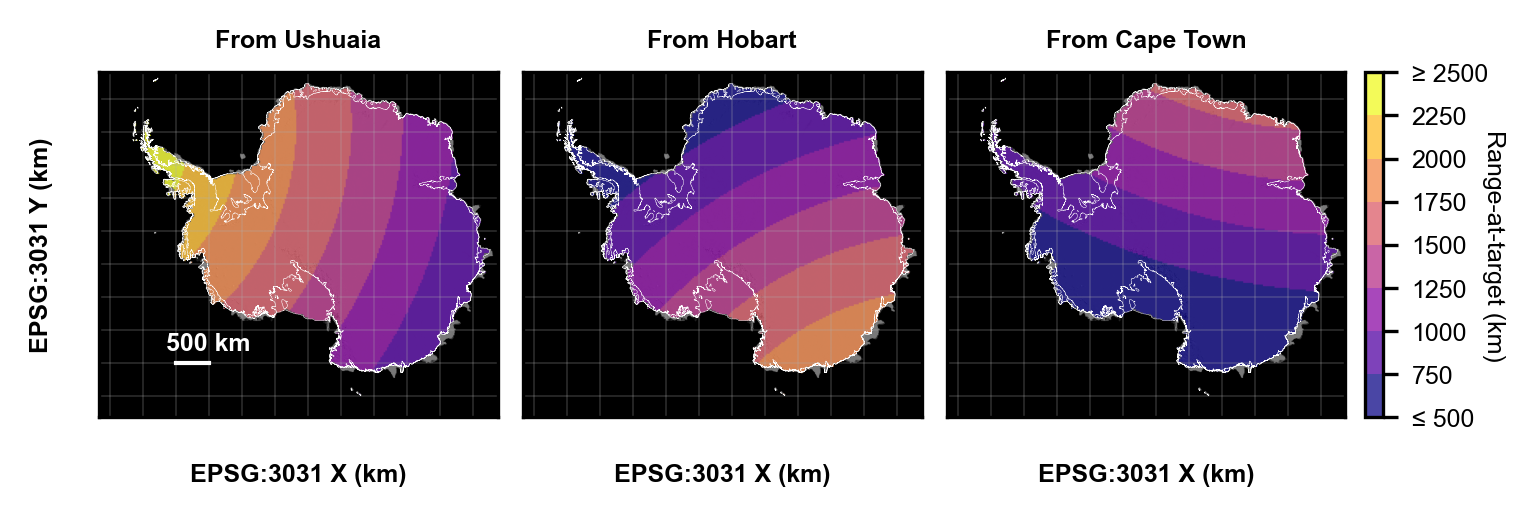

In [193]:
num_color = 8
range_set = np.linspace(5e2, 2.5e3, 1 + num_color)
cmap = plt.colormaps['plasma'].resampled(num_color)
fig, ax = plt.subplots(1, 3, figsize=(5, 2), dpi=300, facecolor='w', layout='constrained')
for base in range(num_base):
    plt.subplot(1, 3, 1 + base)
    plt.imshow(moa[::10, ::10], extent=(x_min_moa, x_max_moa, y_max_moa, y_min_moa), aspect='equal', cmap='gray')    
    plt.imshow(range_grd[:, :, base] / 2e3, extent=(np.min(x_bm), np.max(x_bm), np.min(y_bm), np.max(y_bm)), aspect='equal', cmap=colors.ListedColormap(cmap(range(num_color))), alpha=0.75)
    if base == 0:
        plt.plot(np.array([-2e6, -1.5e6]), np.array([-2e6, -2e6]), 'w', linewidth=1)
        plt.text(-2.15e6, -1.8e6, '500 km', font='Arial', size=6, weight='bold', color='w')
    plt.axis(np.array((x_min_moa, x_max_moa, y_max_moa, y_min_moa)))
    plt.clim(range_temp[[0, -1]])
    moa_gl.boundary.plot(color='w', ax=ax[base], linewidth=0.1)
    moa_cl.boundary.plot(color='w', ax=ax[base], linewidth=0.1)
    moa_il.boundary.plot(color='w', ax=ax[base], linewidth=0.1)
    plt.xlabel('EPSG:3031 X (km)', font='Arial', size=6, fontweight='bold')
    if base == 0:
        plt.ylabel('EPSG:3031 Y (km)', font='Arial', size=6, fontweight='bold')
    plt.title('From ' + base_gdf.Name[base], font='Arial', size=6, fontweight='bold')
    plt.xticks(ticks=np.arange(-3e6, 2.5e6 + 5e5, 5e5))
    plt.yticks(ticks=np.arange(-2.5e6, 2.0e6 + 5e5, 5e5))
    plt.gca().axes.set_xticklabels([])
    plt.gca().axes.set_yticklabels([])
    plt.gca().axes.label_outer(remove_inner_ticks=True)
    plt.tick_params(bottom=False, left=False)
    plt.grid(linewidth=0.1)
    if base == (num_base - 1):
        cb_label = range_set.astype(int).astype(str)
        cb_label[0] = '≤ ' + cb_label[0]
        cb_label[-1] = '≥ ' + cb_label[-1]       
        cb = plt.colorbar(shrink=0.6)
        cb.set_ticks(range_set, labels=cb_label, font='Arial', fontsize=6)
        cb.set_label('Range-at-target (km)', font='Arial', fontsize=6, rotation=270)
plt.show()